In [ ]:
# Importing necessary libraries for image processing, data analysis, and machine learning tasks
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from ultralytics import YOLO
import random
import shutil
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [ ]:
# Defining paths for data, images, and labels to organize and access the dataset efficiently
DATA_PATH = "/kaggle/input/videodata/videodataset 2/videodataset"  
IMAGES_PATH = os.path.join(DATA_PATH, "img")
LABELS_PATH = os.path.join(DATA_PATH, "labels")


In [ ]:
# Retrieving all image and label file paths for further processing and analysis
image_files = glob.glob(os.path.join(IMAGES_PATH, "*.jpg"))
label_files = glob.glob(os.path.join(LABELS_PATH, "*.txt"))


In [ ]:
# Displaying the total number of images and label files to verify dataset consistency
print(f"Total images: {len(image_files)}")
print(f"Total label files: {len(label_files)}")


Total images: 3331
Total label files: 3331


In [ ]:
# Counting occurrences of each class in the label files to analyze class distribution
class_counts = Counter()
for label_file in label_files:
    with open(label_file, "r") as f:
        for line in f:
            class_id = line.split()[0]
            class_counts[class_id] += 1


In [ ]:
# Creating a DataFrame to visualize and analyze the distribution of classes in the dataset
class_df = pd.DataFrame(class_counts.items(), columns=["Class ID", "Count"])
print(class_df)


  Class ID  Count
0        0   9710
1        3    326
2        1   1829
3        2   1166


In [ ]:
# Visualizing sample images with bounding boxes and class IDs to verify annotation correctness and dataset quality
def show_sample_images(num_samples=5):
    samples = image_files[:num_samples]
    plt.figure(figsize=(15, 5))
    
    for i, img_path in enumerate(samples):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label_path = os.path.join(LABELS_PATH, os.path.basename(img_path).replace(".jpg", ".txt"))
        
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    data = line.strip().split()
                    class_id, x_center, y_center, width, height = map(float, data)
                    h, w, _ = img.shape
                    x1, y1 = int((x_center - width / 2) * w), int((y_center - height / 2) * h)
                    x2, y2 = int((x_center + width / 2) * w), int((y_center + height / 2) * h)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.show()


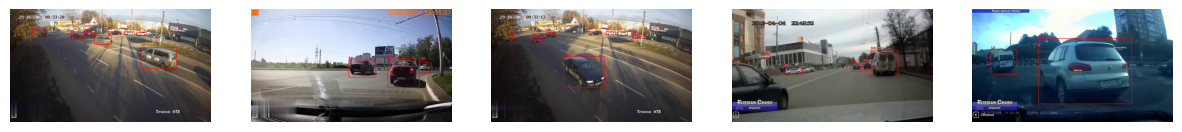

In [9]:
show_sample_images(5)

In [ ]:
# Merging two datasets and correcting class IDs in the labels to ensure consistency and compatibility in the combined dataset
import shutil
from pathlib import Path

dataset1_images = Path("/kaggle/input/videodata/videodataset 2/videodataset/img")
dataset1_labels = Path("/kaggle/input/videodata/videodataset 2/videodataset/labels")
dataset2_images = Path("/kaggle/input/car-sevraccid/train/images")
dataset2_labels = Path("/kaggle/input/car-sevraccid/train/labels")

merged_images = Path("/kaggle/working/merged_dataset999/images")
merged_labels = Path("/kaggle/working/merged_dataset999/labels")

merged_images.mkdir(parents=True, exist_ok=True)
merged_labels.mkdir(parents=True, exist_ok=True)

for img_path in list(dataset1_images.glob("*.jpg")) + list(dataset2_images.glob("*.jpg")):
    shutil.copy(img_path, merged_images / img_path.name)

correction_map = {0: 4, 1: 5, 2: 6, 3: 7, 4: 8} 

for label_file in dataset1_labels.glob("*.txt"):
    shutil.copy(label_file, merged_labels / label_file.name)

for label_file in dataset2_labels.glob("*.txt"):
    with open(label_file, "r") as f:
        lines = f.readlines()

    updated_lines = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])  
        if class_id in correction_map:
            parts[0] = str(correction_map[class_id]) 
        updated_lines.append(" ".join(parts) + "\n")

    with open(merged_labels / label_file.name, "w") as f:
        f.writelines(updated_lines)

print("DONER!")


DONER!


In [ ]:

print(f" Merged images: {len(list((Path('/kaggle/working/merged_dataset999') / 'images').glob('*.jpg')))}")
print(f" Merged labels: {len(list((Path('/kaggle/working/merged_dataset999') / 'labels').glob('*.txt')))}")


 Merged images: 4762
 Merged labels: 4762


In [ ]:
# Splitting the dataset into train, validation, and test sets while maintaining corresponding image-label pairs for model training and evaluation
dataset_path = Path("/kaggle/working/merged_dataset999")  
images_dir = dataset_path / "images"  
labels_dir = dataset_path / "labels"  

output_dir = Path("/kaggle/working/split_dataset")
train_img_dir, val_img_dir, test_img_dir = [output_dir / f"{x}/images" for x in ["train", "val", "test"]]
train_lbl_dir, val_lbl_dir, test_lbl_dir = [output_dir / f"{x}/labels" for x in ["train", "val", "test"]]

for d in [train_img_dir, val_img_dir, test_img_dir, train_lbl_dir, val_lbl_dir, test_lbl_dir]:
    d.mkdir(parents=True, exist_ok=True)

image_files = list(images_dir.glob("*.jpg"))  
random.shuffle(image_files)  

total = len(image_files)
train_split, val_split = int(0.7 * total), int(0.9 * total)

train_files = image_files[:train_split]
val_files = image_files[train_split:val_split]
test_files = image_files[val_split:]

def move_files(files, img_dest, lbl_dest):
    for img_path in files:
        shutil.copy(img_path, img_dest / img_path.name)  
        label_path = labels_dir / f"{img_path.stem}.txt"
        if label_path.exists():
            shutil.copy(label_path, lbl_dest / label_path.name)  

move_files(train_files, train_img_dir, train_lbl_dir)
move_files(val_files, val_img_dir, val_lbl_dir)
move_files(test_files, test_img_dir, test_lbl_dir)

print(f" Done! Data split into train ({len(train_files)}), val ({len(val_files)}), test ({len(test_files)})")


✅ Done! Data split into train (3333), val (952), test (477)


In [ ]:
# Creating a YAML configuration file to define dataset paths, number of classes, and class names for YOLO model training
import yaml

data_yaml = {
    "train": str(train_img_dir), 
    "val": str(val_img_dir),     
    "test": str(test_img_dir),    
    "nc": 9, 
    "names": ['car','truck', 'accident', 'motorcycles','fire', 'minor', 'moderate', 'no_accident', 'severe'] 
}

yaml_path = output_dir / "data.yaml"
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f" data.yaml created at {yaml_path}")


✅ data.yaml created at /kaggle/working/split_dataset/data.yaml


In [ ]:
# Analyzing class distribution in the training labels to ensure balanced representation and verify class mappings
labels_dir = "/kaggle/working/split_dataset/train/labels" 
yaml_file = "/kaggle/working/split_dataset/data.yaml"  

with open(yaml_file, "r") as f:
    data = yaml.safe_load(f)
    class_names = data.get("names", [])

label_files = glob.glob(os.path.join(labels_dir, "*.txt"))

class_counts = {}

for file in label_files:
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if line.strip():  
                class_id = int(line.split()[0])  
                class_counts[class_id] = class_counts.get(class_id, 0) + 1

print(f"Total unique classes: {len(class_counts)}")
print("Class ID  |  Count  |  Class Name")
print("-" * 40)

for class_id, count in sorted(class_counts.items()):
    class_name = class_names[class_id] if class_id < len(class_names) else "Unknown"
    print(f"{class_id:<9} | {count:<6}  | {class_name}")


Total unique classes: 9
Class ID  |  Count  |  Class Name
----------------------------------------
0         | 6832    | car
1         | 1281    | truck
2         | 813     | accident
3         | 211     | motorcycles
4         | 349     | fire
5         | 49      | minor
6         | 61      | moderate
7         | 274     | no_accident
8         | 546     | severe


In [ ]:
pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 13.8 MB/s eta 0:00:00a 0:00:01


In [15]:
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


In [16]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model1 = YOLO("yolov5mu.pt")
results = model1.train(
    data="/kaggle/working/split_dataset/data.yaml",  
    epochs=32, 
    imgsz=640, 
    device=[0], 
    auto_augment='randaugment', 
      
    project="Accident_detection", name="First",
    workers=0,
    show=True
)

100%|██████████| 48.2M/48.2M [00:00<00:00, 191MB/s]


Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov5mu.pt, data=/kaggle/working/split_dataset/data.yaml, epochs=32, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=0, project=Accident_detection, name=First, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=True, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

100%|██████████| 755k/755k [00:00<00:00, 17.5MB/s]


Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1      5280  ultralytics.nn.modules.conv.Conv             [3, 48, 6, 2, 2]              
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2     65280  ultralytics.nn.modules.block.C3              [96, 96, 2]                   
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    444672  ultralytics.nn.modules.block.C3              [192, 192, 4]                 
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  6   2512896  ultralytics.nn.modules.block.C3              [384, 384, 6]                 
  7                  -1  1   2655744  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.9MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/split_dataset/train/labels... 3333 images, 163 backgrounds, 0 corrupt: 100%|██████████| 3333/3333 [00:03<00:00, 1060.87it/s]


train: New cache created: /kaggle/working/split_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/split_dataset/val/labels... 952 images, 42 backgrounds, 0 corrupt: 100%|██████████| 952/952 [00:00<00:00, 1052.90it/s]


val: New cache created: /kaggle/working/split_dataset/val/labels.cache
Plotting labels to Accident_detection/First/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 91 weight(decay=0.0), 98 weight(decay=0.0005), 97 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to Accident_detection/First
Starting training for 32 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/32      7.96G      1.218      1.408      1.176         30        640: 100%|██████████| 209/209 [02:52<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.84it/s]

                   all        952       2979      0.661      0.396      0.384      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/32       7.9G      1.208      1.124      1.189         24        640: 100%|██████████| 209/209 [02:49<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.02it/s]

                   all        952       2979      0.587      0.373      0.388      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/32      7.89G      1.183      1.062      1.175         30        640: 100%|██████████| 209/209 [02:49<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.03it/s]

                   all        952       2979      0.622      0.439      0.432      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/32      7.88G      1.164      1.008      1.158         16        640: 100%|██████████| 209/209 [02:45<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.07it/s]

                   all        952       2979       0.64      0.372      0.413      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/32      8.02G      1.115     0.9271      1.134         42        640: 100%|██████████| 209/209 [02:44<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.06it/s]

                   all        952       2979      0.713      0.549      0.538      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/32      7.96G      1.083     0.8725      1.111         40        640: 100%|██████████| 209/209 [02:43<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.09it/s]

                   all        952       2979      0.762      0.507      0.551      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/32      7.97G      1.058      0.832        1.1         13        640: 100%|██████████| 209/209 [02:43<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.12it/s]

                   all        952       2979      0.706      0.524      0.526       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/32      7.88G      1.039     0.8076      1.094         37        640: 100%|██████████| 209/209 [02:42<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.09it/s]

                   all        952       2979      0.742      0.543      0.571      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/32      8.02G      1.024     0.7795       1.08         30        640: 100%|██████████| 209/209 [02:43<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.13it/s]

                   all        952       2979       0.78      0.562      0.597      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/32      7.97G      1.018     0.7718       1.08         27        640: 100%|██████████| 209/209 [02:42<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.11it/s]

                   all        952       2979       0.78      0.569        0.6      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/32      7.96G      0.996     0.7394      1.068         31        640: 100%|██████████| 209/209 [02:42<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.13it/s]

                   all        952       2979      0.743      0.592      0.586      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/32      7.88G     0.9829     0.7088      1.058         36        640: 100%|██████████| 209/209 [02:42<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.14it/s]

                   all        952       2979      0.817      0.589      0.626      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/32         8G     0.9757     0.6941      1.057         32        640: 100%|██████████| 209/209 [02:43<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.09it/s]

                   all        952       2979      0.694      0.606      0.646      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/32      7.96G     0.9625     0.6957      1.051         25        640: 100%|██████████| 209/209 [02:43<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.08it/s]

                   all        952       2979      0.792      0.611      0.646      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/32      7.95G     0.9486      0.668      1.044         37        640: 100%|██████████| 209/209 [02:43<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.11it/s]

                   all        952       2979      0.865      0.601      0.661      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/32      7.88G     0.9314     0.6552      1.039         33        640: 100%|██████████| 209/209 [02:42<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.11it/s]

                   all        952       2979      0.812      0.632      0.661      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/32      8.01G     0.9244     0.6456      1.037         32        640: 100%|██████████| 209/209 [02:42<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.13it/s]

                   all        952       2979      0.831      0.605      0.655      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/32      7.97G     0.9108     0.6261      1.028         24        640: 100%|██████████| 209/209 [02:42<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.13it/s]

                   all        952       2979      0.594        0.7      0.666      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/32      7.97G     0.9036     0.6174      1.025         25        640: 100%|██████████| 209/209 [02:42<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:14<00:00,  2.13it/s]

                   all        952       2979      0.742      0.659      0.678      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/32      7.88G      0.897     0.5928      1.015         83        640:  54%|█████▍    | 113/209 [01:29<01:18,  1.23it/s]

In [21]:
model = YOLO("/kaggle/working/Accident_detection/First/weights/best.pt")  

test_images_path = "/kaggle/working/split_dataset/test/images" 
image_paths = glob.glob(f"{test_images_path}/*.jpg")  

sample_images = random.sample(image_paths, 10)

results = model(sample_images, imgsz=640, conf=0.5)  




0: 640x640 4 cars, 10.3ms
1: 640x640 1 car, 1 truck, 10.3ms
2: 640x640 2 cars, 2 motorcycless, 10.3ms
3: 640x640 1 severe, 10.3ms
4: 640x640 1 truck, 1 accident, 10.3ms
5: 640x640 2 cars, 10.3ms
6: 640x640 5 cars, 3 trucks, 10.3ms
7: 640x640 6 cars, 1 truck, 10.3ms
8: 640x640 1 car, 10.3ms
9: 640x640 6 cars, 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


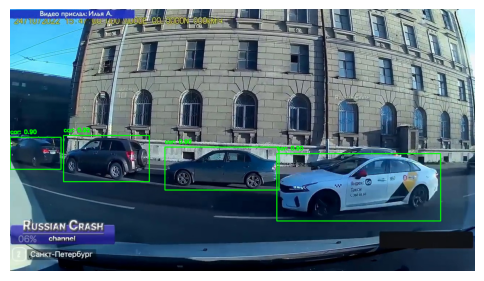

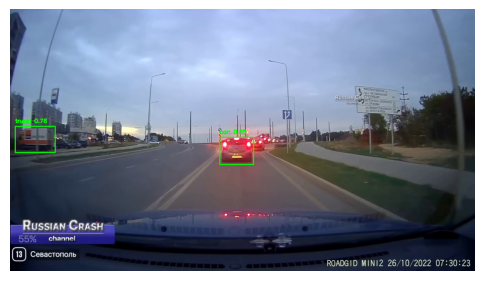

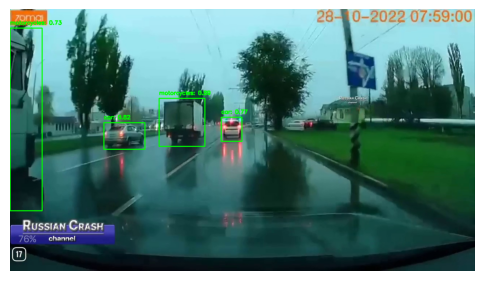

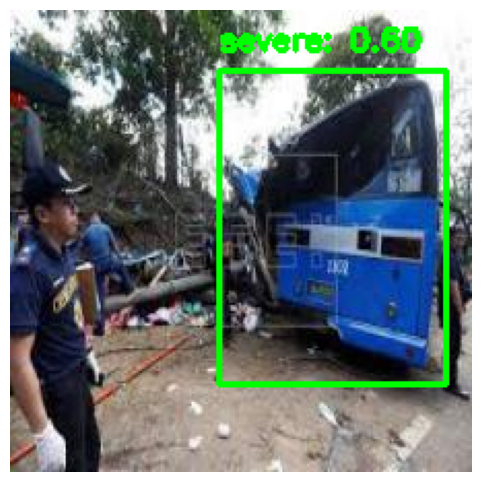

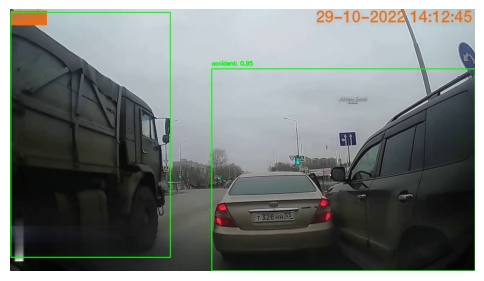

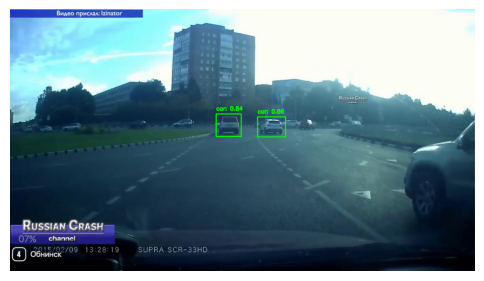

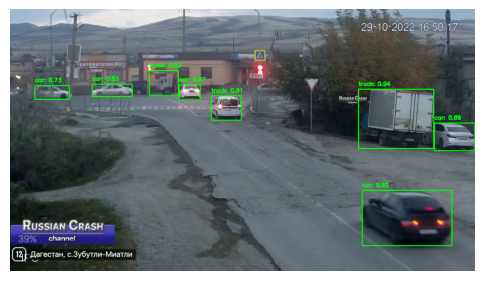

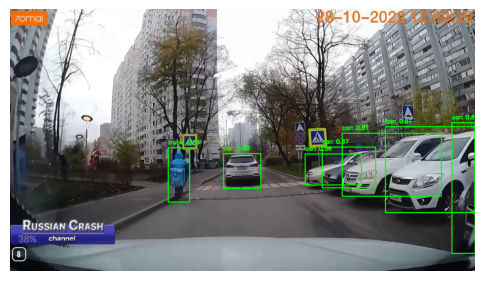

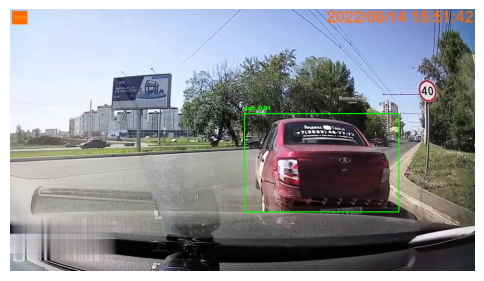

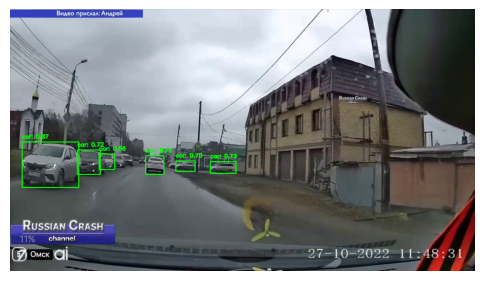

In [22]:
for img_path, result in zip(sample_images, results):
    img = cv2.imread(img_path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  
        class_id = int(box.cls[0]) 
        confidence = box.conf[0].item()  
        class_name = class_names[class_id]  
        
        color = (0, 255, 0)  
        thickness = 2
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
        
        text = f"{class_name}: {confidence:.2f}"
        cv2.putText(img, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()



0: 640x640 1 moderate, 2 severes, 15.6ms
Speed: 2.1ms preprocess, 15.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Predictions: [{'class_id': 8, 'class_name': 'severe', 'confidence': 0.6287841200828552, 'box': [0.0, 346.2919921875, 256.4599914550781, 640.0]}, {'class_id': 8, 'class_name': 'severe', 'confidence': 0.4751876890659332, 'box': [190.09771728515625, 2.7679443359375, 618.021240234375, 530.7276611328125]}, {'class_id': 6, 'class_name': 'moderate', 'confidence': 0.36714550852775574, 'box': [161.406494140625, 0.0, 621.8876953125, 521.4436645507812]}]


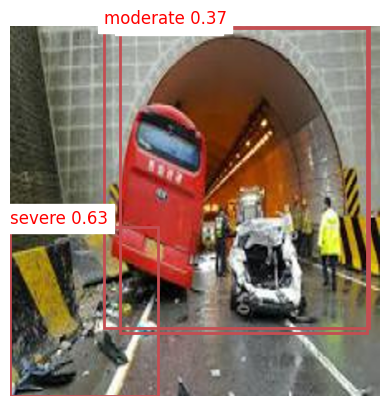

Image Analysis Results: /kaggle/input/car-sevraccid/test/images/images_066_jpg.rf.3304cac4789961d827871c4958d68445.jpg
Accident Severity: Severe Accident
Surrounding Risk Severity: No Risk to Surroundings
Number of Cars Nearby: 0
Number of Trucks Nearby: 0
--------------------------------------------------

0: 640x640 1 severe, 15.6ms
Speed: 1.7ms preprocess, 15.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Predictions: [{'class_id': 8, 'class_name': 'severe', 'confidence': 0.8261865377426147, 'box': [2.22137451171875, 2.931121826171875, 639.3451538085938, 406.5576477050781]}]


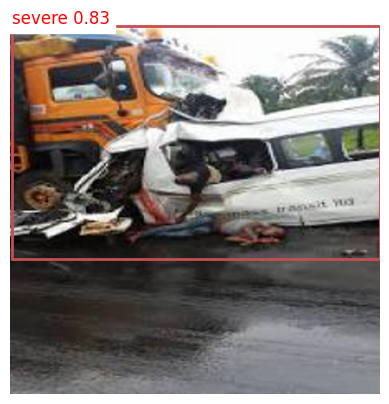

Image Analysis Results: /kaggle/input/car-sevraccid/test/images/images_051_jpg.rf.ae668a0ca0c2d25d814868e8c3f6440b.jpg
Accident Severity: Severe Accident
Surrounding Risk Severity: No Risk to Surroundings
Number of Cars Nearby: 0
Number of Trucks Nearby: 0
--------------------------------------------------

0: 640x640 2 cars, 2 trucks, 15.6ms
Speed: 1.9ms preprocess, 15.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Predictions: [{'class_id': 0, 'class_name': 'car', 'confidence': 0.8612366914749146, 'box': [318.37445068359375, 349.130615234375, 404.72222900390625, 467.836181640625]}, {'class_id': 1, 'class_name': 'truck', 'confidence': 0.8220458626747131, 'box': [49.76226806640625, 242.81031799316406, 195.89137268066406, 461.2867431640625]}, {'class_id': 0, 'class_name': 'car', 'confidence': 0.6638530492782593, 'box': [211.90933227539062, 350.69580078125, 266.0223388671875, 427.109375]}, {'class_id': 1, 'class_name': 'truck', 'confidence': 0.6611379384994507, 'box

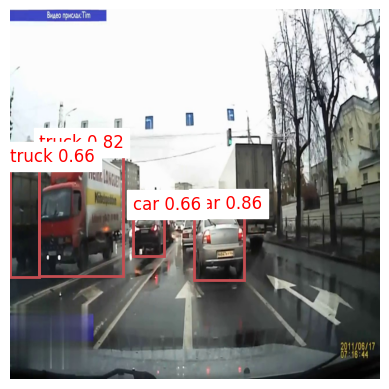

Image Analysis Results: /kaggle/input/videodata/videodataset 2/videodataset/img/w1-12_frame0029.jpg
Accident Severity: No Accident Detected
Surrounding Risk Severity: Medium Risk to Surroundings
Number of Cars Nearby: 2
Number of Trucks Nearby: 2
--------------------------------------------------


In [114]:
import torch
from PIL import Image
import numpy as np
import matplotlib.patches as patches
# Load the YOLOv5mu model

# Function to determine accident severity based on model predictions
def determine_accident_severity(predictions):
    if any(p['class_name'] == 'severe' for p in predictions):
        return "Severe Accident"
    if any(p['class_name'] == 'fire' for p in predictions):
        return "Severe Accident"

    elif any(p['class_name'] == 'moderate' for p in predictions):
        return "Moderate Accident"
    elif any(p['class_name'] == 'minor' for p in predictions):
        return "Minor Accident"
    elif any(p['class_name'] == 'accident' for p in predictions):
        return "Minor Accident"
    else:
        return "No Accident Detected"

# Function to determine the severity of the accident on surroundings based on the number of cars and trucks
def determine_surrounding_severity(cars, trucks):
    total_vehicles = cars + trucks
    if total_vehicles >= 5:
        return "High Risk to Surroundings"
    elif 3 <= total_vehicles < 5:
        return "Medium Risk to Surroundings"
    elif 1 <= total_vehicles < 3:
        return "Low Risk to Surroundings"
    else:
        return "No Risk to Surroundings"
def plot_image_with_boxes(image, predictions):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    for pred in predictions:
        class_name = pred['class_name']
        confidence = pred['confidence']
        box = pred['box']
        
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        label = f"{class_name} {confidence:.2f}"
        ax.text(xmin, ymin - 5, label, color='red', fontsize=12, backgroundcolor='white')
    
    plt.axis('off')
    plt.show()
# Function to process the image and apply the model
def process_image(image_path):
    # Load and resize the image to 640x640
    image = Image.open(image_path)
    image = image.resize((640, 640))
    image = np.array(image)
    
    # Apply the model to the image
    results = model(image)
    # print(f"Type of results: {type(results)}")
    # print(f"Results: {results}")
    if isinstance(results, list):
        results = results[0]  

    if hasattr(results, 'boxes'):
        
        boxes = results.boxes
        predictions = []
        for box in boxes:
            class_id = int(box.cls) 
            class_name = results.names[class_id] 
            confidence = float(box.conf)  
            predictions.append({
                'class_id': class_id,
                'class_name': class_name,
                'confidence': confidence,
                'box': box.xyxy[0].tolist()
            })
    else:
        raise AttributeError("No 'boxes' attribute found in results.")
    
    print(f"Predictions: {predictions}")
    plot_image_with_boxes(image, predictions)
    # Count the number of cars and trucks
    cars = len([p for p in predictions if p['class_name'] == 'car'])
    trucks = len([p for p in predictions if p['class_name'] == 'truck'])
    
    # Determine accident severity
    accident_severity = determine_accident_severity(predictions)    
    # Determine the severity of the accident on surroundings
    surrounding_severity = determine_surrounding_severity(cars, trucks)
    
    # Display the results
    print(f"Image Analysis Results: {image_path}")
    print(f"Accident Severity: {accident_severity}")
    print(f"Surrounding Risk Severity: {surrounding_severity}")
    print(f"Number of Cars Nearby: {cars}")
    print(f"Number of Trucks Nearby: {trucks}")
    print("-" * 50)

# List of image paths
image_paths = ['/kaggle/input/car-sevraccid/test/images/images_066_jpg.rf.3304cac4789961d827871c4958d68445.jpg',
               '/kaggle/input/car-sevraccid/test/images/images_051_jpg.rf.ae668a0ca0c2d25d814868e8c3f6440b.jpg',
               '/kaggle/input/videodata/videodataset 2/videodataset/img/w1-12_frame0029.jpg']  # Replace with your image paths

# Process each image in the list
for image_path in image_paths:
    process_image(image_path)